In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler
from torch_geometric.nn import GINConv, global_max_pool
from torch_geometric.data import Data, Batch
import tifffile
import random
from scipy.spatial import Delaunay
from tqdm import tqdm

import spacegm

## SPACE-GM Implementation
# This implementation follows the SPACE-GM workflow with the following steps:
# 1. Construct cellular graphs with raw inputs
# 2. Construct dataset and attach node-level / graph-level tasks
# 3. Initialize a Graph Neural Network (GNN) according to the prediction tasks
# 4. Train the GNN by randomly sampling subgraphs
# 5. Evaluate the GNN on node-level / graph-level tasks

In [2]:
region_id = "region1"
biomarker_file = "../data/data/CRC01/P37_S29-CRC01.csv"
output_folder = "../data/data/CRC01/sep_info"
df = pd.read_csv(biomarker_file)
print(df.head())

   CellID      Hoechst          AF1        CD31        CD45        CD68  \
0       1  1395.636054   201.984694  198.634354  216.879252  218.404762   
1       2   485.206757  1175.447297  391.706757  443.291892  235.802703   
2       3   506.274611   241.689119  223.777202  197.005181  195.839378   
3       4  1543.056373   365.200980  245.198529  217.242647  217.151961   
4       5  1149.718206   397.612450  236.649264  225.673360  224.076305   

      Argo550         CD4       FOXP3        CD8a  ...          SMA  \
0  187.260204  216.454082  187.838435  189.663265  ...   158.722789   
1  209.760811  252.935135  240.941892  271.004054  ...   190.736486   
2  187.212435  197.803109  186.367876  192.072539  ...   162.968912   
3  198.546569  263.014706  202.159314  212.928922  ...  1700.906863   
4  203.301205  258.234270  203.374163  216.769076  ...  1289.707497   

     X_centroid  Y_centroid  Area  MajorAxisLength  MinorAxisLength  \
0   2971.392857    7.275510   588        41.882124 

Dataset preview:


,CellID,Hoechst,AF1,CD31,CD45,CD68,Argo550,CD4,FOXP3,CD8a,...,SMA,X_centroid,Y_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation
0,1,1395.636054,201.984694,198.634354,216.879252,218.404762,187.260204,216.454082,187.838435,189.663265,...,158.722789,2971.392857,7.275510,588,41.882124,18.370334,0.898673,0.981636,0.864706,1.533761
1,2,485.206757,1175.447297,391.706757,443.291892,235.802703,209.760811,252.935135,240.941892,271.004054,...,190.736486,6705.512162,8.860811,740,43.965194,22.187973,0.863312,0.946292,0.764463,-1.530993
2,3,506.274611,241.689119,223.777202,197.005181,195.839378,187.212435,197.803109,186.367876,192.072539,...,162.968912,6733.823834,6.300518,193,18.694776,13.708441,0.679931,0.914692,0.756863,-0.904913
3,4,1543.056373,365.200980,245.198529,217.242647,217.151961,198.546569,263.014706,202.159314,212.928922,...,1700.906863,10972.629902,10.174020,408,23.768887,21.976172,0.380995,0.978417,0.771267,0.603646
4,5,1149.718206,397.612450,236.649264,225.673360,224.076305,203.301205,258.234270,203.374163,216.769076,...,1289.707497,11259.722222,20.623159,1494,74.087383,26.469302,0.934001,0.918254,0.507473,0.967785



Total cells in dataset: 1620375
Biomarker columns: ['Hoechst', 'AF1', 'CD31', 'CD45', 'CD68', 'Argo550', 'CD4', 'FOXP3', 'CD8a', 'CD45RO', 'CD20', 'PD-L1', 'CD3e', 'CD163', 'E-cadherin', 'PD-1', 'Ki67', 'Pan-CK', 'SMA']
Morphological feature columns: ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation']

Constructing cell interaction graph (with parallel processing)...
Preparing data for graph construction...
   CellID   BM-HOECHST       BM-AF1     BM-CD31     BM-CD45     BM-CD68  \
0       1  1395.636054   201.984694  198.634354  216.879252  218.404762   
1       2   485.206757  1175.447297  391.706757  443.291892  235.802703   
2       3   506.274611   241.689119  223.777202  197.005181  195.839378   
3       4  1543.056373   365.200980  245.198529  217.242647  217.151961   
4       5  1149.718206   397.612450  236.649264  225.673360  224.076305   

   BM-ARGO550      BM-CD4    BM-FOXP3     BM-CD8A   BM-CD45RO     BM-CD20  \
0  187.26020

Processing Delaunay triangles:   0%|          | 0/1511 [00:00<?, ?it/s]

Adding edges to graph...


Creating edges:   0%|          | 0/1620375 [00:00<?, ?it/s]

Calculating Voronoi polygons...
Assigning node and edge attributes...


Assigning node attributes:   0%|          | 0/1620375 [00:00<?, ?it/s]

Calculating edge types...


Computing edge properties:   0%|          | 0/4861096 [00:00<?, ?it/s]

Saving Voronoi polygon visualization...
Saving graph visualization...
Graph construction complete: 1620375 nodes, 4861096 edges
Graph construction completed in 10290.87 seconds


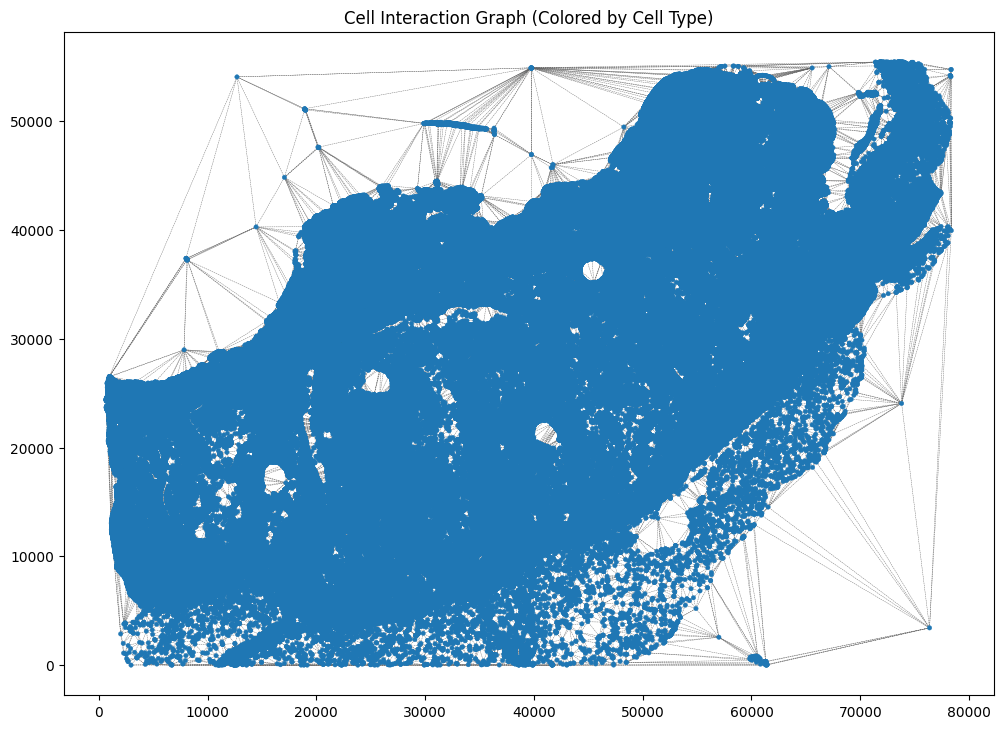


Graph Analysis:
Number of nodes (cells): 1620375
Number of edges (interactions): 4861096
Average connectivity: 6.00 neighbors per cell
Maximum connectivity: 30 neighbors
Minimum connectivity: 3 neighbors
Neighbor edges: 4246579 (87.4%)
Distant edges: 614517 (12.6%)

Analyzing cell type interactions (parallel)...
Analyzing cell interactions using 151 cores...


Processing edge batches:   0%|          | 0/1511 [00:00<?, ?it/s]

/home/jesseliu/miniconda3/envs/spacegm/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from cell_graph import construct_graph_from_dataframe, plot_graph, plot_voronoi_polygons
from tqdm.notebook import tqdm
import multiprocessing
from joblib import Parallel, delayed
import time

# Set up figure size for visualizations
plt.rcParams['figure.figsize'] = (12, 12)


df = pd.read_csv(biomarker_file)

# Display the first few rows of the dataframe
print("Dataset preview:")
display(df.head())

# Column configuration for your specific data structure
x_col = 'X_centroid'
y_col = 'Y_centroid'
cell_id_col = 'CellID'

# Identify your biomarker columns
biomarker_cols = [
    'Hoechst', 'AF1', 'CD31', 'CD45', 'CD68', 'Argo550', 'CD4', 'FOXP3', 
    'CD8a', 'CD45RO', 'CD20', 'PD-L1', 'CD3e', 'CD163', 'E-cadherin', 
    'PD-1', 'Ki67', 'Pan-CK', 'SMA'
]

# We need to rename these to have the 'BM-' prefix expected by the code
for col in biomarker_cols:
    df[f'BM_{col}'] = df[col]

# Print information about the data
print(f"\nTotal cells in dataset: {len(df)}")
print(f"Biomarker columns: {biomarker_cols}")

# Morphological feature columns from your data
feature_cols = ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 
               'Solidity', 'Extent', 'Orientation']
print(f"Morphological feature columns: {feature_cols}")

# Function to determine cell type based on marker expression
def classify_cell(row):
    # These thresholds should be adjusted based on your data
    threshold = df[biomarker_cols].mean().median()  # Simple heuristic
    
    # Some example classifications - customize these based on your markers and biology
    if row['CD3e'] > threshold and row['CD4'] > threshold:
        return 'CD4+ T cell'
    elif row['CD3e'] > threshold and row['CD8a'] > threshold:
        return 'CD8+ T cell'
    elif row['CD20'] > threshold:
        return 'B cell'
    elif row['CD68'] > threshold or row['CD163'] > threshold:
        return 'Macrophage'
    elif row['CD31'] > threshold:
        return 'Endothelial'
    elif row['Pan-CK'] > threshold or row['E-cadherin'] > threshold:
        return 'Epithelial'
    elif row['SMA'] > threshold:
        return 'Stromal'
    else:
        return 'Other'

# Parallel version of classify_cell
def parallel_classify_cells(dataframe, marker_cols):
    # Pre-calculate threshold to avoid redundant calculations
    threshold = dataframe[marker_cols].mean().median()
    
    # Create a modified classify function that uses the pre-calculated threshold
    def classify_single_row(i):
        row = dataframe.iloc[i]
        if row['CD3e'] > threshold and row['CD4'] > threshold:
            return 'CD4+ T cell'
        elif row['CD3e'] > threshold and row['CD8a'] > threshold:
            return 'CD8+ T cell'
        elif row['CD20'] > threshold:
            return 'B cell'
        elif row['CD68'] > threshold or row['CD163'] > threshold:
            return 'Macrophage'
        elif row['CD31'] > threshold:
            return 'Endothelial'
        elif row['Pan-CK'] > threshold or row['E-cadherin'] > threshold:
            return 'Epithelial'
        elif row['SMA'] > threshold:
            return 'Stromal'
        else:
            return 'Other'
    
    # Determine number of cores to use (leave one free for system)
    n_cores = max(1, multiprocessing.cpu_count() - 1)
    print(f"Using {n_cores} CPU cores for parallel processing")
    
    # Process in parallel
    start_time = time.time()
    results = Parallel(n_jobs=n_cores)(
        delayed(classify_single_row)(i) for i in tqdm(range(len(dataframe)), desc="Classifying cells")
    )
    elapsed = time.time() - start_time
    print(f"Classification completed in {elapsed:.2f} seconds")
    
    return results


# print("Classifying cells based on marker expression (parallel processing)...")
# df['CELL_TYPE'] = parallel_classify_cells(df, biomarker_cols)

# cell_type_counts = df['CELL_TYPE'].value_counts()
# for cell_type, count in cell_type_counts.items():
#     print(f"  {cell_type}: {count} cells ({count/len(df)*100:.1f}%)")

# Modify construct_graph_from_dataframe to use parallel processing
def construct_graph_from_dataframe_parallel(df, **kwargs):
    """Wrapper around construct_graph_from_dataframe with parallel processing optimizations"""
    
    # Initialize a simple Delaunay triangulation in parallel
    def build_graph_from_coords_parallel(coords_df):
        from scipy.spatial import Delaunay
        import networkx as nx
        
        print("Computing Delaunay triangulation...")
        coord_ar = np.array(coords_df[['CellID', 'X', 'Y']])
        G = nx.Graph()
        node_to_cell_mapping = {}
        for i, row in enumerate(coord_ar):
            G.add_node(i)
            node_to_cell_mapping[i] = row[0]
        
        # Compute Delaunay triangulation
        dln = Delaunay(coord_ar[:, 1:3])
        
        # Initialize neighbors lists
        neighbors = [set() for _ in range(len(coord_ar))]
        
        # Process triangulation in parallel
        n_cores = max(1, multiprocessing.cpu_count() - 1)
        
        def process_triangle_batch(batch_simplices):
            batch_neighbors = [set() for _ in range(len(coord_ar))]
            for simplex in batch_simplices:
                for v in simplex:
                    batch_neighbors[v].update(simplex)
            return batch_neighbors
        
        # Split simplices into batches
        batch_size = max(1, len(dln.simplices) // (n_cores * 10))
        simplex_batches = [dln.simplices[i:i + batch_size] for i in range(0, len(dln.simplices), batch_size)]
        
        print(f"Processing {len(simplex_batches)} batches of triangles in parallel...")
        batch_results = Parallel(n_jobs=n_cores)(
            delayed(process_triangle_batch)(batch) for batch in tqdm(simplex_batches, desc="Processing Delaunay triangles")
        )
        
        # Merge results
        for batch_neighbor in batch_results:
            for i, neighbor_set in enumerate(batch_neighbor):
                neighbors[i].update(neighbor_set)
        
        # Create edges
        print("Adding edges to graph...")
        for i, ns in tqdm(enumerate(neighbors), desc="Creating edges", total=len(neighbors)):
            for n in ns:
                if i != n:  # Avoid self-loops
                    G.add_edge(int(i), int(n))
        
        return G, node_to_cell_mapping
    
    # Override certain parameters for better performance
    # First, process the DataFrame
    process_kwargs = {
        'x_col': kwargs.get('x_col', 'X_centroid'),
        'y_col': kwargs.get('y_col', 'Y_centroid'),
        'cell_id_col': kwargs.get('cell_id_col', 'CellID'),
        'cell_type_col': kwargs.get('cell_type_col', 'CELL_TYPE'),
        'biomarker_prefix': kwargs.get('biomarker_prefix', ['BM_']),
        'feature_cols': kwargs.get('feature_cols', None)
    }
    
    from cell_graph import process_dataframe_for_graph
    coords_df, types_df, biomarker_df, features_df = process_dataframe_for_graph(df, **process_kwargs)

    # Start with cell coordinates data
    cell_data = coords_df
    
    # Merge other dataframes
    if types_df is not None:
        print("Merging cell type data...")
        cell_data = cell_data.merge(types_df, on='CellID', how='left')
    
    if biomarker_df is not None:
        print("Merging biomarker data...")
        cell_data = cell_data.merge(biomarker_df, on='CellID', how='left')
    
    if features_df is not None:
        print("Merging feature data...")
        cell_data = cell_data.merge(features_df, on='CellID', how='left')
    
    # Build the graph with our parallel implementation
    G, node_to_cell_mapping = build_graph_from_coords_parallel(cell_data)
    
    # For Voronoi polygons, we'll calculate them in the main thread
    # since this isn't the bottleneck
    from cell_graph import calcualte_voronoi_from_coords
    print("Calculating Voronoi polygons...")
    voronoi_polygons = calcualte_voronoi_from_coords(cell_data['X'], cell_data['Y'])
    
    # Add Voronoi polygons to nodes
    for i, node in enumerate(G.nodes()):
        if i < len(voronoi_polygons):
            G.nodes[node]['voronoi_polygon'] = voronoi_polygons[i]
    
    # Process the rest of the graph construction using the original function
    from cell_graph import assign_attributes
    print("Assigning node and edge attributes...")
    G = assign_attributes(G, cell_data, node_to_cell_mapping, 
                         edge_kwargs=kwargs.get('edge_kwargs', {}))
    G.region_id = kwargs.get('region_id', 'region')
    
    # Save visualizations if requested
    if kwargs.get('voronoi_polygon_img_output') or kwargs.get('graph_img_output'):
        import matplotlib.pyplot as plt
        from cell_graph import plot_voronoi_polygons, plot_graph
        
        figsize = kwargs.get('figsize', 12)
        
        if kwargs.get('voronoi_polygon_img_output'):
            print(f"Saving Voronoi polygon visualization...")
            plt.figure(figsize=(figsize, figsize))
            plot_voronoi_polygons(G)
            plt.axis('scaled')
            plt.savefig(kwargs['voronoi_polygon_img_output'], dpi=300, bbox_inches='tight')
            plt.close()
        
        if kwargs.get('graph_img_output'):
            print(f"Saving graph visualization...")
            plt.figure(figsize=(figsize, figsize))
            plot_graph(G)
            plt.axis('scaled')
            plt.savefig(kwargs['graph_img_output'], dpi=300, bbox_inches='tight')
            plt.close()
    
    print(f"Graph construction complete: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

# Construct the graph with parallel processing
print("\nConstructing cell interaction graph (with parallel processing)...")
start_time = time.time()
G = construct_graph_from_dataframe_parallel(
    df,
    region_id="tissue_section",
    x_col=x_col,
    y_col=y_col,
    cell_id_col=cell_id_col,
    # cell_type_col='CELL_TYPE',
    biomarker_prefix=['BM_'],
    feature_cols=feature_cols,
    graph_source='cell',
    voronoi_polygon_img_output="voronoi_visualization.png",
    graph_img_output="graph_visualization.png",
    figsize=12
)
elapsed = time.time() - start_time
print(f"Graph construction completed in {elapsed:.2f} seconds")

# Visualize the graph colored by cell type
plt.figure(figsize=(12, 12))
plot_graph(G)
plt.title("Cell Interaction Graph (Colored by Cell Type)")
plt.axis('scaled')
plt.show()

# Basic graph analysis
print(f"\nGraph Analysis:")
print(f"Number of nodes (cells): {G.number_of_nodes()}")
print(f"Number of edges (interactions): {G.number_of_edges()}")

# Calculate and display graph metrics
degrees = [d for n, d in G.degree()]
print(f"Average connectivity: {np.mean(degrees):.2f} neighbors per cell")
print(f"Maximum connectivity: {np.max(degrees)} neighbors")
print(f"Minimum connectivity: {np.min(degrees)} neighbors")

# Display the distribution of neighbor vs. distant edges
edge_types = [data['edge_type'] for u, v, data in G.edges(data=True)]
neighbor_count = edge_types.count('neighbor')
distant_count = edge_types.count('distant')
print(f"Neighbor edges: {neighbor_count} ({neighbor_count/len(edge_types)*100:.1f}%)")
print(f"Distant edges: {distant_count} ({distant_count/len(edge_types)*100:.1f}%)")

# Parallel version of cell type interaction analysis
def analyze_cell_interactions_parallel(G):
    start_time = time.time()
    
    n_cores = max(1, multiprocessing.cpu_count() - 1)
    print(f"Analyzing cell interactions using {n_cores} cores...")
    
    # Function to process a batch of edges
    def process_edge_batch(edge_batch):
        batch_interactions = {}
        for u, v, data in edge_batch:
            if data['edge_type'] == 'neighbor':
                u_type = G.nodes[u]['cell_type']
                v_type = G.nodes[v]['cell_type']
                key = tuple(sorted([u_type, v_type]))
                if key not in batch_interactions:
                    batch_interactions[key] = 0
                batch_interactions[key] += 1
        return batch_interactions
    
    # Get all edges with data
    all_edges = list(G.edges(data=True))
    
    # Split into batches
    batch_size = max(1, len(all_edges) // (n_cores * 10))
    edge_batches = [all_edges[i:i + batch_size] for i in range(0, len(all_edges), batch_size)]
    
    # Process in parallel
    batch_results = Parallel(n_jobs=n_cores)(
        delayed(process_edge_batch)(batch) for batch in tqdm(edge_batches, desc="Processing edge batches")
    )
    
    # Merge results
    interactions = {}
    for batch_result in batch_results:
        for key, count in batch_result.items():
            if key not in interactions:
                interactions[key] = 0
            interactions[key] += count
    
    elapsed = time.time() - start_time
    print(f"Cell interaction analysis completed in {elapsed:.2f} seconds")
    return interactions

# Now let's look at cell type interactions using parallel processing
print("\nAnalyzing cell type interactions (parallel)...")
interactions = analyze_cell_interactions_parallel(G)

# Display the top interaction pairs
print("Most frequent cell-cell interactions:")
for (type1, type2), count in sorted(interactions.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {type1} - {type2}: {count} interactions")

# Parallel biomarker analysis
def analyze_biomarkers_parallel(df, biomarker_cols):
    start_time = time.time()
    
    # This is a simple calculation that doesn't need much parallelization
    results = {}
    for biomarker in tqdm(biomarker_cols, desc="Analyzing biomarkers"):
        values = df[biomarker].values
        results[biomarker] = {
            'mean': values.mean(),
            'median': np.median(values),
            'std': values.std()
        }
    
    elapsed = time.time() - start_time
    print(f"Biomarker analysis completed in {elapsed:.2f} seconds")
    return results

# Analyze biomarker expression patterns
print("\nAnalyzing biomarker expression patterns (parallel)...")
biomarker_stats = analyze_biomarkers_parallel(df, biomarker_cols)

print("Biomarker expression statistics:")
for biomarker, stats in list(biomarker_stats.items())[:5]:  # Showing first 5 biomarkers for brevity
    print(f"  {biomarker}: mean={stats['mean']:.3f}, median={stats['median']:.3f}, std={stats['std']:.3f}")

# Create biomarker heatmap by cell type more efficiently
print("\nGenerating biomarker expression heatmap by cell type...")
# This is a groupby operation which pandas optimizes internally
cell_type_biomarker_means = df.groupby('CELL_TYPE')[biomarker_cols].mean()

plt.figure(figsize=(14, 8))
plt.imshow(cell_type_biomarker_means, aspect='auto', cmap='viridis')
plt.colorbar(label='Mean Expression')
plt.xticks(range(len(biomarker_cols)), biomarker_cols, rotation=90)
plt.yticks(range(len(cell_type_biomarker_means.index)), cell_type_biomarker_means.index)
plt.title('Mean Biomarker Expression by Cell Type')
plt.tight_layout()
plt.show()

# Parallel community detection
def detect_communities_parallel(G):
    start_time = time.time()
    try:
        from cdlib import algorithms
        import networkx as nx
        
        print("Preparing graph for community detection...")
        # Remove distant edges for community detection (focus on neighboring cells)
        neighbor_G = nx.Graph()
        
        # Function to process a batch of edges
        def process_edge_batch_for_community(edge_batch):
            local_edges = []
            for u, v, data in edge_batch:
                if data['edge_type'] == 'neighbor':
                    local_edges.append((u, v))
            return local_edges
        
        # Process edges in parallel
        n_cores = max(1, multiprocessing.cpu_count() - 1)
        all_edges = list(G.edges(data=True))
        batch_size = max(1, len(all_edges) // (n_cores * 10))
        edge_batches = [all_edges[i:i + batch_size] for i in range(0, len(all_edges), batch_size)]
        
        batch_results = Parallel(n_jobs=n_cores)(
            delayed(process_edge_batch_for_community)(batch) for batch in tqdm(edge_batches, desc="Processing edges for community detection")
        )
        
        # Add edges to community graph
        for batch_edges in batch_results:
            for u, v in batch_edges:
                neighbor_G.add_edge(u, v)
        
        # Add node attributes
        for n, data in G.nodes(data=True):
            neighbor_G.add_node(n, **data)
        
        print(f"Running Louvain community detection algorithm...")
        communities = algorithms.louvain(neighbor_G)
        
        elapsed = time.time() - start_time
        print(f"Community detection completed in {elapsed:.2f} seconds")
        return communities, neighbor_G
    except ImportError:
        print("cdlib package not installed. To perform community detection, install with: pip install cdlib")
        return None, None


print("\nPerforming community detection (parallel)...")
communities, community_G = detect_communities_parallel(G)

if communities:
    print(f"Detected {len(communities.communities)} communities")
    
    plt.figure(figsize=(12, 12))
    
    node_colors = []
    node_to_community = {}
    for i, comm in enumerate(communities.communities):
        for node in comm:
            node_to_community[node] = i
    
    for node in G.nodes:
        if node in node_to_community:
            node_colors.append(node_to_community[node])
        else:
            node_colors.append(-1)
    
    cmap = plt.cm.get_cmap('tab20', len(communities.communities))
    node_colors = [cmap(i % 20) if i >= 0 else (0.7, 0.7, 0.7, 1.0) for i in node_colors]
    
    plot_graph(G, node_colors=node_colors)
    plt.title("Community Structure of Cell Network")
    plt.show()
    
    def analyze_community_composition(communities, G, n_communities=5):
        results = []
        
        def process_community(i, comm):
            if len(comm) > 0:
                cell_types = [G.nodes[n]['cell_type'] for n in comm]
                type_counts = pd.Series(cell_types).value_counts()
                return i, len(comm), type_counts
            return i, 0, None
        
        n_cores = max(1, multiprocessing.cpu_count() - 1)
        communities_to_process = list(enumerate(communities.communities[:n_communities]))
        
        results = Parallel(n_jobs=n_cores)(
            delayed(process_community)(i, comm) for i, comm in tqdm(communities_to_process, desc="Analyzing communities")
        )
        
        return results
    
    print("\nCommunity composition by cell type:")
    community_results = analyze_community_composition(communities, G)
    
    for i, size, type_counts in community_results:
        if size > 0:
            print(f"Community {i} ({size} cells):")
            for ct, count in type_counts.items():
                print(f"  {ct}: {count} cells ({count/size*100:.1f}%)")

print("\nSaving graph to disk...")
import pickle
with open('cell_graph.pkl', 'wb') as f:
    pickle.dump(G, f)
print("Graph saved to 'cell_graph.pkl'")

nx.write_graphml(G, "cell_graph.graphml")
print("Graph also saved in GraphML format for use with Cytoscape or other tools")

print("\nParallel analysis complete!")

Dataset preview:


,CellID,Hoechst,AF1,CD31,CD45,CD68,Argo550,CD4,FOXP3,CD8a,...,SMA,X_centroid,Y_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation
0,1,1395.636054,201.984694,198.634354,216.879252,218.404762,187.260204,216.454082,187.838435,189.663265,...,158.722789,2971.392857,7.275510,588,41.882124,18.370334,0.898673,0.981636,0.864706,1.533761
1,2,485.206757,1175.447297,391.706757,443.291892,235.802703,209.760811,252.935135,240.941892,271.004054,...,190.736486,6705.512162,8.860811,740,43.965194,22.187973,0.863312,0.946292,0.764463,-1.530993
2,3,506.274611,241.689119,223.777202,197.005181,195.839378,187.212435,197.803109,186.367876,192.072539,...,162.968912,6733.823834,6.300518,193,18.694776,13.708441,0.679931,0.914692,0.756863,-0.904913
3,4,1543.056373,365.200980,245.198529,217.242647,217.151961,198.546569,263.014706,202.159314,212.928922,...,1700.906863,10972.629902,10.174020,408,23.768887,21.976172,0.380995,0.978417,0.771267,0.603646
4,5,1149.718206,397.612450,236.649264,225.673360,224.076305,203.301205,258.234270,203.374163,216.769076,...,1289.707497,11259.722222,20.623159,1494,74.087383,26.469302,0.934001,0.918254,0.507473,0.967785



Total cells in dataset: 1620375
Biomarker columns: ['Hoechst', 'AF1', 'CD31', 'CD45', 'CD68', 'Argo550', 'CD4', 'FOXP3', 'CD8a', 'CD45RO', 'CD20', 'PD-L1', 'CD3e', 'CD163', 'E-cadherin', 'PD-1', 'Ki67', 'Pan-CK', 'SMA']
Morphological feature columns: ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation']

Constructing cell interaction graph (with parallel processing)...
Preparing data for graph construction...
Merging cell type data...
Merging biomarker data...
Merging feature data...
Computing Delaunay triangulation...
Processing 1511 batches of triangles in parallel...


Processing Delaunay triangles:   0%|          | 0/1511 [00:00<?, ?it/s]

Adding edges to graph...


Creating edges:   0%|          | 0/1620375 [00:00<?, ?it/s]

Calculating Voronoi polygons...
Assigning node and edge attributes...


Assigning node attributes:   0%|          | 0/1620375 [00:00<?, ?it/s]

Calculating edge types...


Computing edge properties:   0%|          | 0/4861096 [00:00<?, ?it/s]

Saving Voronoi polygon visualization...
Saving graph visualization...
Graph construction complete: 1620375 nodes, 4861096 edges
Graph construction completed in 10341.15 seconds


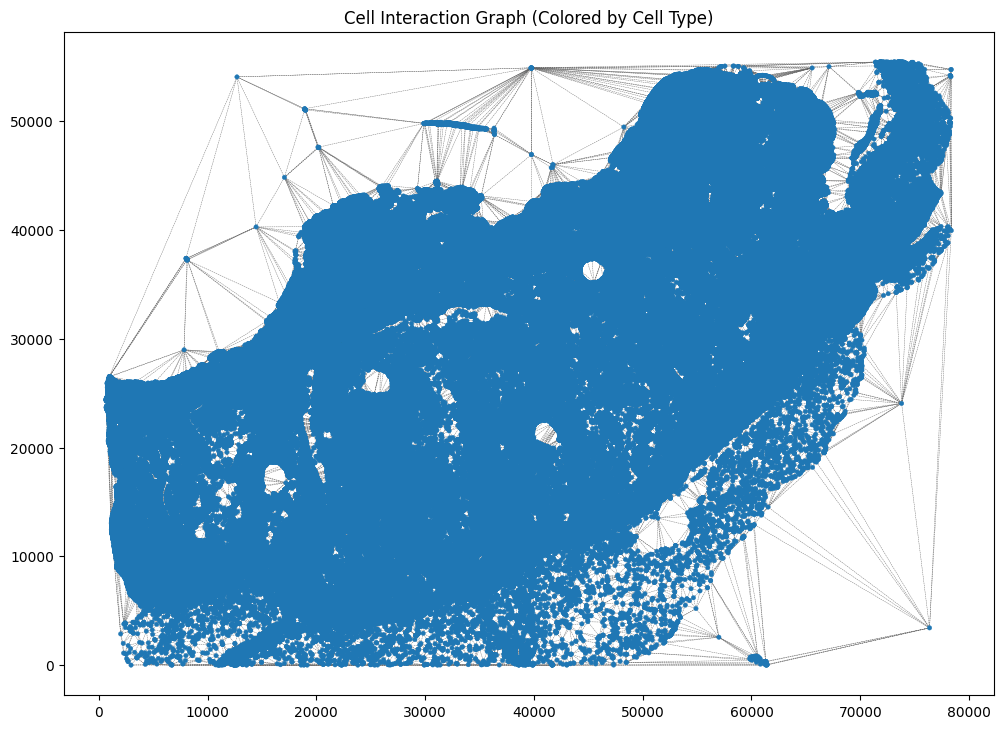


Graph Analysis:
Number of nodes (cells): 1620375
Number of edges (interactions): 4861096
Average connectivity: 6.00 neighbors per cell
Maximum connectivity: 30 neighbors
Minimum connectivity: 3 neighbors
Neighbor edges: 4246579 (87.4%)
Distant edges: 614517 (12.6%)

Analyzing cell type interactions (parallel)...
Analyzing cell interactions using 151 cores...


Processing edge batches:   0%|          | 0/1511 [00:00<?, ?it/s]

/home/jesseliu/miniconda3/envs/spacegm/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from cell_graph import construct_graph_from_dataframe, plot_graph, plot_voronoi_polygons
from tqdm.notebook import tqdm
import multiprocessing
from joblib import Parallel, delayed
import time

# Set up figure size for visualizations
plt.rcParams['figure.figsize'] = (12, 12)


df = pd.read_csv(biomarker_file)

# Display the first few rows of the dataframe
print("Dataset preview:")
display(df.head())

# Column configuration for your specific data structure
x_col = 'X_centroid'
y_col = 'Y_centroid'
cell_id_col = 'CellID'

# Identify your biomarker columns
biomarker_cols = [
    'Hoechst', 'AF1', 'CD31', 'CD45', 'CD68', 'Argo550', 'CD4', 'FOXP3', 
    'CD8a', 'CD45RO', 'CD20', 'PD-L1', 'CD3e', 'CD163', 'E-cadherin', 
    'PD-1', 'Ki67', 'Pan-CK', 'SMA'
]

# We need to rename these to have the 'BM-' prefix expected by the code
for col in biomarker_cols:
    df[f'BM_{col}'] = df[col]

# Print information about the data
print(f"\nTotal cells in dataset: {len(df)}")
print(f"Biomarker columns: {biomarker_cols}")

# Morphological feature columns from your data
feature_cols = ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 
               'Solidity', 'Extent', 'Orientation']
print(f"Morphological feature columns: {feature_cols}")

# Function to determine cell type based on marker expression
def classify_cell(row):
    # These thresholds should be adjusted based on your data
    threshold = df[biomarker_cols].mean().median()  # Simple heuristic
    
    # Some example classifications - customize these based on your markers and biology
    if row['CD3e'] > threshold and row['CD4'] > threshold:
        return 'CD4+ T cell'
    elif row['CD3e'] > threshold and row['CD8a'] > threshold:
        return 'CD8+ T cell'
    elif row['CD20'] > threshold:
        return 'B cell'
    elif row['CD68'] > threshold or row['CD163'] > threshold:
        return 'Macrophage'
    elif row['CD31'] > threshold:
        return 'Endothelial'
    elif row['Pan-CK'] > threshold or row['E-cadherin'] > threshold:
        return 'Epithelial'
    elif row['SMA'] > threshold:
        return 'Stromal'
    else:
        return 'Other'

# Parallel version of classify_cell
def parallel_classify_cells(dataframe, marker_cols):
    # Pre-calculate threshold to avoid redundant calculations
    threshold = dataframe[marker_cols].mean().median()
    
    # Create a modified classify function that uses the pre-calculated threshold
    def classify_single_row(i):
        row = dataframe.iloc[i]
        if row['CD3e'] > threshold and row['CD4'] > threshold:
            return 'CD4+ T cell'
        elif row['CD3e'] > threshold and row['CD8a'] > threshold:
            return 'CD8+ T cell'
        elif row['CD20'] > threshold:
            return 'B cell'
        elif row['CD68'] > threshold or row['CD163'] > threshold:
            return 'Macrophage'
        elif row['CD31'] > threshold:
            return 'Endothelial'
        elif row['Pan-CK'] > threshold or row['E-cadherin'] > threshold:
            return 'Epithelial'
        elif row['SMA'] > threshold:
            return 'Stromal'
        else:
            return 'Other'
    
    # Determine number of cores to use (leave one free for system)
    n_cores = max(1, multiprocessing.cpu_count() - 1)
    print(f"Using {n_cores} CPU cores for parallel processing")
    
    # Process in parallel
    start_time = time.time()
    results = Parallel(n_jobs=n_cores)(
        delayed(classify_single_row)(i) for i in tqdm(range(len(dataframe)), desc="Classifying cells")
    )
    elapsed = time.time() - start_time
    print(f"Classification completed in {elapsed:.2f} seconds")
    
    return results


# print("Classifying cells based on marker expression (parallel processing)...")
# df['CELL_TYPE'] = parallel_classify_cells(df, biomarker_cols)

# cell_type_counts = df['CELL_TYPE'].value_counts()
# for cell_type, count in cell_type_counts.items():
#     print(f"  {cell_type}: {count} cells ({count/len(df)*100:.1f}%)")

# Modify construct_graph_from_dataframe to use parallel processing
def construct_graph_from_dataframe_parallel(df, **kwargs):
    """Wrapper around construct_graph_from_dataframe with parallel processing optimizations"""
    
    # Initialize a simple Delaunay triangulation in parallel
    def build_graph_from_coords_parallel(coords_df):
        from scipy.spatial import Delaunay
        import networkx as nx
        
        print("Computing Delaunay triangulation...")
        coord_ar = np.array(coords_df[['CellID', 'X', 'Y']])
        G = nx.Graph()
        node_to_cell_mapping = {}
        for i, row in enumerate(coord_ar):
            G.add_node(i)
            node_to_cell_mapping[i] = row[0]
        
        # Compute Delaunay triangulation
        dln = Delaunay(coord_ar[:, 1:3])
        
        # Initialize neighbors lists
        neighbors = [set() for _ in range(len(coord_ar))]
        
        # Process triangulation in parallel
        n_cores = max(1, multiprocessing.cpu_count() - 1)
        
        def process_triangle_batch(batch_simplices):
            batch_neighbors = [set() for _ in range(len(coord_ar))]
            for simplex in batch_simplices:
                for v in simplex:
                    batch_neighbors[v].update(simplex)
            return batch_neighbors
        
        # Split simplices into batches
        batch_size = max(1, len(dln.simplices) // (n_cores * 10))
        simplex_batches = [dln.simplices[i:i + batch_size] for i in range(0, len(dln.simplices), batch_size)]
        
        print(f"Processing {len(simplex_batches)} batches of triangles in parallel...")
        batch_results = Parallel(n_jobs=n_cores)(
            delayed(process_triangle_batch)(batch) for batch in tqdm(simplex_batches, desc="Processing Delaunay triangles")
        )
        
        # Merge results
        for batch_neighbor in batch_results:
            for i, neighbor_set in enumerate(batch_neighbor):
                neighbors[i].update(neighbor_set)
        
        # Create edges
        print("Adding edges to graph...")
        for i, ns in tqdm(enumerate(neighbors), desc="Creating edges", total=len(neighbors)):
            for n in ns:
                if i != n:  # Avoid self-loops
                    G.add_edge(int(i), int(n))
        
        return G, node_to_cell_mapping
    
    # Override certain parameters for better performance
    # First, process the DataFrame
    process_kwargs = {
        'x_col': kwargs.get('x_col', 'X_centroid'),
        'y_col': kwargs.get('y_col', 'Y_centroid'),
        'cell_id_col': kwargs.get('cell_id_col', 'CellID'),
        'cell_type_col': kwargs.get('cell_type_col', 'CELL_TYPE'),
        'biomarker_prefix': kwargs.get('biomarker_prefix', ['BM_']),
        'feature_cols': kwargs.get('feature_cols', None)
    }
    
    from cell_graph import process_dataframe_for_graph
    coords_df, types_df, biomarker_df, features_df = process_dataframe_for_graph(df, **process_kwargs)

    # Start with cell coordinates data
    cell_data = coords_df
    
    # Merge other dataframes
    if types_df is not None:
        print("Merging cell type data...")
        cell_data = cell_data.merge(types_df, on='CellID', how='left')
    
    if biomarker_df is not None:
        print("Merging biomarker data...")
        cell_data = cell_data.merge(biomarker_df, on='CellID', how='left')
    
    if features_df is not None:
        print("Merging feature data...")
        cell_data = cell_data.merge(features_df, on='CellID', how='left')
    
    # Build the graph with our parallel implementation
    G, node_to_cell_mapping = build_graph_from_coords_parallel(cell_data)
    
    # For Voronoi polygons, we'll calculate them in the main thread
    # since this isn't the bottleneck
    from cell_graph import calcualte_voronoi_from_coords
    print("Calculating Voronoi polygons...")
    voronoi_polygons = calcualte_voronoi_from_coords(cell_data['X'], cell_data['Y'])
    
    # Add Voronoi polygons to nodes
    for i, node in enumerate(G.nodes()):
        if i < len(voronoi_polygons):
            G.nodes[node]['voronoi_polygon'] = voronoi_polygons[i]
    
    # Process the rest of the graph construction using the original function
    from cell_graph import assign_attributes
    print("Assigning node and edge attributes...")
    G = assign_attributes(G, cell_data, node_to_cell_mapping, 
                         edge_kwargs=kwargs.get('edge_kwargs', {}))
    G.region_id = kwargs.get('region_id', 'region')
    
    # Save visualizations if requested
    if kwargs.get('voronoi_polygon_img_output') or kwargs.get('graph_img_output'):
        import matplotlib.pyplot as plt
        from cell_graph import plot_voronoi_polygons, plot_graph
        
        figsize = kwargs.get('figsize', 12)
        
        if kwargs.get('voronoi_polygon_img_output'):
            print(f"Saving Voronoi polygon visualization...")
            plt.figure(figsize=(figsize, figsize))
            plot_voronoi_polygons(G)
            plt.axis('scaled')
            plt.savefig(kwargs['voronoi_polygon_img_output'], dpi=300, bbox_inches='tight')
            plt.close()
        
        if kwargs.get('graph_img_output'):
            print(f"Saving graph visualization...")
            plt.figure(figsize=(figsize, figsize))
            plot_graph(G)
            plt.axis('scaled')
            plt.savefig(kwargs['graph_img_output'], dpi=300, bbox_inches='tight')
            plt.close()
    
    print(f"Graph construction complete: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

# Construct the graph with parallel processing
print("\nConstructing cell interaction graph (with parallel processing)...")
start_time = time.time()
G = construct_graph_from_dataframe_parallel(
    df,
    region_id="tissue_section",
    x_col=x_col,
    y_col=y_col,
    cell_id_col=cell_id_col,
    # cell_type_col='CELL_TYPE',
    biomarker_prefix=['BM_'],
    feature_cols=feature_cols,
    graph_source='cell',
    voronoi_polygon_img_output="voronoi_visualization.png",
    graph_img_output="graph_visualization.png",
    figsize=12
)
elapsed = time.time() - start_time
print(f"Graph construction completed in {elapsed:.2f} seconds")

# Visualize the graph colored by cell type
plt.figure(figsize=(12, 12))
plot_graph(G)
plt.title("Cell Interaction Graph (Colored by Cell Type)")
plt.axis('scaled')
plt.show()

# Basic graph analysis
print(f"\nGraph Analysis:")
print(f"Number of nodes (cells): {G.number_of_nodes()}")
print(f"Number of edges (interactions): {G.number_of_edges()}")

# Calculate and display graph metrics
degrees = [d for n, d in G.degree()]
print(f"Average connectivity: {np.mean(degrees):.2f} neighbors per cell")
print(f"Maximum connectivity: {np.max(degrees)} neighbors")
print(f"Minimum connectivity: {np.min(degrees)} neighbors")

# Display the distribution of neighbor vs. distant edges
edge_types = [data['edge_type'] for u, v, data in G.edges(data=True)]
neighbor_count = edge_types.count('neighbor')
distant_count = edge_types.count('distant')
print(f"Neighbor edges: {neighbor_count} ({neighbor_count/len(edge_types)*100:.1f}%)")
print(f"Distant edges: {distant_count} ({distant_count/len(edge_types)*100:.1f}%)")

# Parallel version of cell type interaction analysis
def analyze_cell_interactions_parallel(G):
    start_time = time.time()
    
    n_cores = max(1, multiprocessing.cpu_count() - 1)
    print(f"Analyzing cell interactions using {n_cores} cores...")
    
    # Function to process a batch of edges
    def process_edge_batch(edge_batch):
        batch_interactions = {}
        for u, v, data in edge_batch:
            if data['edge_type'] == 'neighbor':
                u_type = G.nodes[u]['cell_type']
                v_type = G.nodes[v]['cell_type']
                key = tuple(sorted([u_type, v_type]))
                if key not in batch_interactions:
                    batch_interactions[key] = 0
                batch_interactions[key] += 1
        return batch_interactions
    
    # Get all edges with data
    all_edges = list(G.edges(data=True))
    
    # Split into batches
    batch_size = max(1, len(all_edges) // (n_cores * 10))
    edge_batches = [all_edges[i:i + batch_size] for i in range(0, len(all_edges), batch_size)]
    
    # Process in parallel
    batch_results = Parallel(n_jobs=n_cores)(
        delayed(process_edge_batch)(batch) for batch in tqdm(edge_batches, desc="Processing edge batches")
    )
    
    # Merge results
    interactions = {}
    for batch_result in batch_results:
        for key, count in batch_result.items():
            if key not in interactions:
                interactions[key] = 0
            interactions[key] += count
    
    elapsed = time.time() - start_time
    print(f"Cell interaction analysis completed in {elapsed:.2f} seconds")
    return interactions

# Now let's look at cell type interactions using parallel processing
print("\nAnalyzing cell type interactions (parallel)...")
interactions = analyze_cell_interactions_parallel(G)

# Display the top interaction pairs
print("Most frequent cell-cell interactions:")
for (type1, type2), count in sorted(interactions.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {type1} - {type2}: {count} interactions")

# Parallel biomarker analysis
def analyze_biomarkers_parallel(df, biomarker_cols):
    start_time = time.time()
    
    # This is a simple calculation that doesn't need much parallelization
    results = {}
    for biomarker in tqdm(biomarker_cols, desc="Analyzing biomarkers"):
        values = df[biomarker].values
        results[biomarker] = {
            'mean': values.mean(),
            'median': np.median(values),
            'std': values.std()
        }
    
    elapsed = time.time() - start_time
    print(f"Biomarker analysis completed in {elapsed:.2f} seconds")
    return results

# Analyze biomarker expression patterns
print("\nAnalyzing biomarker expression patterns (parallel)...")
biomarker_stats = analyze_biomarkers_parallel(df, biomarker_cols)

print("Biomarker expression statistics:")
for biomarker, stats in list(biomarker_stats.items())[:5]:  # Showing first 5 biomarkers for brevity
    print(f"  {biomarker}: mean={stats['mean']:.3f}, median={stats['median']:.3f}, std={stats['std']:.3f}")

# Create biomarker heatmap by cell type more efficiently
print("\nGenerating biomarker expression heatmap by cell type...")
# This is a groupby operation which pandas optimizes internally
cell_type_biomarker_means = df.groupby('CELL_TYPE')[biomarker_cols].mean()

plt.figure(figsize=(14, 8))
plt.imshow(cell_type_biomarker_means, aspect='auto', cmap='viridis')
plt.colorbar(label='Mean Expression')
plt.xticks(range(len(biomarker_cols)), biomarker_cols, rotation=90)
plt.yticks(range(len(cell_type_biomarker_means.index)), cell_type_biomarker_means.index)
plt.title('Mean Biomarker Expression by Cell Type')
plt.tight_layout()
plt.show()

# Parallel community detection
def detect_communities_parallel(G):
    start_time = time.time()
    try:
        from cdlib import algorithms
        import networkx as nx
        
        print("Preparing graph for community detection...")
        # Remove distant edges for community detection (focus on neighboring cells)
        neighbor_G = nx.Graph()
        
        # Function to process a batch of edges
        def process_edge_batch_for_community(edge_batch):
            local_edges = []
            for u, v, data in edge_batch:
                if data['edge_type'] == 'neighbor':
                    local_edges.append((u, v))
            return local_edges
        
        # Process edges in parallel
        n_cores = max(1, multiprocessing.cpu_count() - 1)
        all_edges = list(G.edges(data=True))
        batch_size = max(1, len(all_edges) // (n_cores * 10))
        edge_batches = [all_edges[i:i + batch_size] for i in range(0, len(all_edges), batch_size)]
        
        batch_results = Parallel(n_jobs=n_cores)(
            delayed(process_edge_batch_for_community)(batch) for batch in tqdm(edge_batches, desc="Processing edges for community detection")
        )
        
        # Add edges to community graph
        for batch_edges in batch_results:
            for u, v in batch_edges:
                neighbor_G.add_edge(u, v)
        
        # Add node attributes
        for n, data in G.nodes(data=True):
            neighbor_G.add_node(n, **data)
        
        print(f"Running Louvain community detection algorithm...")
        communities = algorithms.louvain(neighbor_G)
        
        elapsed = time.time() - start_time
        print(f"Community detection completed in {elapsed:.2f} seconds")
        return communities, neighbor_G
    except ImportError:
        print("cdlib package not installed. To perform community detection, install with: pip install cdlib")
        return None, None


print("\nPerforming community detection (parallel)...")
communities, community_G = detect_communities_parallel(G)

if communities:
    print(f"Detected {len(communities.communities)} communities")
    
    plt.figure(figsize=(12, 12))
    
    node_colors = []
    node_to_community = {}
    for i, comm in enumerate(communities.communities):
        for node in comm:
            node_to_community[node] = i
    
    for node in G.nodes:
        if node in node_to_community:
            node_colors.append(node_to_community[node])
        else:
            node_colors.append(-1)
    
    cmap = plt.cm.get_cmap('tab20', len(communities.communities))
    node_colors = [cmap(i % 20) if i >= 0 else (0.7, 0.7, 0.7, 1.0) for i in node_colors]
    
    plot_graph(G, node_colors=node_colors)
    plt.title("Community Structure of Cell Network")
    plt.show()
    
    def analyze_community_composition(communities, G, n_communities=5):
        results = []
        
        def process_community(i, comm):
            if len(comm) > 0:
                cell_types = [G.nodes[n]['cell_type'] for n in comm]
                type_counts = pd.Series(cell_types).value_counts()
                return i, len(comm), type_counts
            return i, 0, None
        
        n_cores = max(1, multiprocessing.cpu_count() - 1)
        communities_to_process = list(enumerate(communities.communities[:n_communities]))
        
        results = Parallel(n_jobs=n_cores)(
            delayed(process_community)(i, comm) for i, comm in tqdm(communities_to_process, desc="Analyzing communities")
        )
        
        return results
    
    print("\nCommunity composition by cell type:")
    community_results = analyze_community_composition(communities, G)
    
    for i, size, type_counts in community_results:
        if size > 0:
            print(f"Community {i} ({size} cells):")
            for ct, count in type_counts.items():
                print(f"  {ct}: {count} cells ({count/size*100:.1f}%)")

print("\nSaving graph to disk...")
import pickle
with open('cell_graph.pkl', 'wb') as f:
    pickle.dump(G, f)
print("Graph saved to 'cell_graph.pkl'")

nx.write_graphml(G, "cell_graph.graphml")
print("Graph also saved in GraphML format for use with Cytoscape or other tools")

print("\nParallel analysis complete!")